In [1]:
import sys
print(sys.executable)

C:\Users\patri\Anaconda3\python.exe


In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install STOPWORDS

Note: you may need to restart the kernel to use updated packages.


In [33]:
import random
import pandas as pd
import numpy as np
import re
import string

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import f1_score, classification_report,confusion_matrix, accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn import pipeline

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection.univariate_selection import chi2, SelectKBest

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn import preprocessing 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [5]:
np.random.seed(500)
stopWords = set(stopwords.words('english'))
stopwords_forCloud = set(STOPWORDS)
stopwords_forCloud.update(['flight', 'flights', 'Flightled', 'AmericanAir', 'VirginAmerica'])

airline = pd.read_csv('C:\\Users\\patri\\Documents\\data mining\\twitter-airline-sentiment\\Tweets.csv',encoding = 'utf8')
airline.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
airline.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
airline.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [8]:
# subset the colums that will be used for analysis
airline_sub = airline.loc[:, ['airline_sentiment', 'airline', 'negativereason', 'text']]

airline_sub.head(10)   

,airline_sentiment,airline,negativereason,text
0,neutral,Virgin America,NaN,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,NaN,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,NaN,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,Bad Flight,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,Can't Tell,@VirginAmerica and it's a really big bad thing...
5,negative,Virgin America,Can't Tell,@VirginAmerica seriously would pay $30 a fligh...
6,positive,Virgin America,NaN,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,Virgin America,NaN,@VirginAmerica Really missed a prime opportuni...
8,positive,Virgin America,NaN,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,Virgin America,NaN,"@VirginAmerica it was amazing, and arrived an ..."


In [9]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color = 'white',
        #contour_width = 3, 
        #contour_color = 'steelblue',
        stopwords = stopwords_forCloud,
        max_words = 80,
        max_font_size = 50, 
        scale = 3,
        random_state = 1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    plt.figure(1, figsize = (10, 12))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()

In [10]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
def lemmatize_text(text):    
    lmtzr = WordNetLemmatizer().lemmatize
    text = word_tokenize(str(text))   # Init the Wordnet Lemmatizer    
    word_pos = pos_tag(text)    
    lemm_words = [lmtzr(sw[0], get_wordnet_pos(sw[1])) for sw in word_pos]
    return (' '.join(lemm_words))

In [11]:
def pre_process(text):       
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)    

    text = emoji_pattern.sub(r'', text)                       # remove emojis       
    text = text.lower()                                       # lower all letters   
    text = re.sub(r'@[A-Za-z0-9]+', '', text)                 # remove user mentions such as @VirginAmerica    
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)       # remove URL

    text = ''.join([t for t in text if t not in string.punctuation])   # remove punctuations       
    text = ''.join([t for t in text if not t.isdigit()])   # remove numeric digits     
    text = re.sub("[^a-zA-Z0-9]", " ", text)   # only leave letters
    text = lemmatize_text(text)   # use Wordnet(lexical database) to lemmatize text     
    return text

##Test one of the messages
pre_process(airline_sub["text"][89])

'why be the site down when will it be back up'

In [12]:
sentiment_count = airline_sub['airline_sentiment'].value_counts()  # negative 9178, neutral 3099, positive 2363
print("airline_sub sentiment_count: ", sentiment_count)

airline_sub['label'] = airline_sub['airline_sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1}) # Negative: -1, neutral: 0, positive 1

# label for doc2vec, because it cannot take -1 as the tag
airline_sub['label_doc2vec'] = airline_sub['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}) # Negative: 0, neutral: 1, positive 2

#airline_sub['processed_text'] =  airline_sub['text'].apply(pre_process)  
airline_sub['processed_text_length'] = airline_sub['text'].apply(lambda x: len(word_tokenize(x)))

airline_sub.head()

airline_sub sentiment_count:  negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


,airline_sentiment,airline,negativereason,text,label,label_doc2vec,processed_text_length
0,neutral,Virgin America,NaN,@VirginAmerica What @dhepburn said.,0,1,7
1,positive,Virgin America,NaN,@VirginAmerica plus you've added commercials t...,1,2,13
2,neutral,Virgin America,NaN,@VirginAmerica I didn't today... Must mean I n...,0,1,16
3,negative,Virgin America,Bad Flight,@VirginAmerica it's really aggressive to blast...,-1,0,24
4,negative,Virgin America,Can't Tell,@VirginAmerica and it's a really big bad thing...,-1,0,12


In [13]:
def Airline_Tweet_Visualization():
    
    # numbers of neutral, positive and neguative reviews.
    sns.set(style="darkgrid")
    sns.countplot(x = 'airline_sentiment', data = airline_sub, order = airline_sub['airline_sentiment'].value_counts().index, palette = 'Set1')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.show()
    
    # numbers of each airline for the frequency of sentiment
    sns.set(style="darkgrid")
    sns.countplot(x = 'airline', data = airline_sub, hue = 'airline_sentiment', order = airline_sub['airline'].value_counts().index, palette = 'Set2')
    plt.xlabel('Airline')
    plt.ylabel('Frequency')
    plt.legend().set_title('Sentiment')
    plt.show()
            
    # frequency of the different negative reasons          
    sns.set(style="darkgrid")
    sns.countplot(y = 'negativereason', data = airline_sub, order = airline_sub['negativereason'].value_counts().index, palette = 'Set3')
    plt.xlabel('Frequency')
    plt.ylabel('Negative Reason')
    plt.show()
    
    # distribution of negative reasons on each airlines
    plt.figure(figsize=(12, 6))
    sns.countplot(x = 'airline', data = airline_sub, hue = 'negativereason', palette = 'Set3', saturation = True)
    plt.xlabel('Airline companies')
    plt.ylabel('Frequency')
    plt.legend(bbox_to_anchor = (1.01, 1), loc = 2, borderaxespad = 0.1)
    plt.show() 
    
    # review length of distribution over neutral, positive and negative sentiment
    sns.boxplot(x = 'airline_sentiment', y = 'processed_text_length', data = airline_sub)    
    plt.xlabel('Sentiment')
    plt.ylabel('Processed Text Length')
    plt.ylim(0, 50)
    plt.show()   
    
    # wordcloud for negative, neutral and positive tweets
    airline_sub_neg = airline_sub.loc[airline_sub['airline_sentiment'] == 'negative']   
    airline_sub_neu = airline_sub.loc[airline_sub['airline_sentiment'] == 'neutral']    
    airline_sub_pos = airline_sub.loc[airline_sub['airline_sentiment'] == 'positive']   

    # show world cloud with negative sentiment
    print('========================world cloud with negative sentiment==================================')
    show_wordcloud(airline_sub_neg['text'])   
    # show world cloud with neutral sentiment
    print('========================world cloud with neutral sentiment==================================')
    show_wordcloud(airline_sub_neu['text'])     
    # show world cloud with positive sentiment  
    print('========================world cloud with positive sentiment==================================')
    show_wordcloud(airline_sub_pos['text'])     
  

In [14]:
def oversampling(train_X):
    df_major_neg = train_X[train_X['label'] == -1]
    df_minor_neu = train_X[train_X['label'] == 0]
    df_minor_pos = train_X[train_X['label'] == 1]        
    major_count = len(df_major_neg)
 
    # oversample minority class
    df_minor_neu_oversampled = resample(df_minor_neu, 
                                 replace = True,              # sample with replacement
                                 n_samples = major_count,     # to match majority class 
                                 random_state = 1000)    

    df_minor_pos_oversampled = resample(df_minor_pos, 
                                 replace = True,             
                                 n_samples = major_count,   
                                 random_state = 1000)      
         
    trainX = pd.concat([df_major_neg, df_minor_neu_oversampled, df_minor_pos_oversampled])   # Combine majority class with oversampled minority class
    print("Train dataset calss distribution: \n", trainX.label.value_counts())
    trainX = shuffle(trainX, random_state = 200) 
    return trainX

def undersampling(train_X):
    df_major_neg = train_X[train_X['label'] == -1]
    df_minor_neu = train_X[train_X['label'] == 0]
    df_minor_pos = train_X[train_X['label'] == 1]        
    minor_count = len(df_minor_pos)
 
    # undersample minority class
    df_major_neg_undersampled = resample(df_major_neg, 
                                 replace = True,              # sample with replacement
                                 n_samples = minor_count,     # to match minority class
                                 random_state = 1000)    

    df_minor_neu_undersampled = resample(df_minor_neu, 
                                 replace = True,             
                                 n_samples = minor_count,   
                                 random_state = 1000)      
         
    trainX = pd.concat([df_major_neg_undersampled, df_minor_neu_undersampled, df_minor_pos])   # Combine majority class with oversampled minority class
    print("Train dataset calss distribution: \n", trainX.label.value_counts())
    trainX = shuffle(trainX, random_state = 200) 
    return trainX

In [15]:
def airline_NB(df, feature, ngram, sample_method):    
    random.seed(999)
        
    if feature == "TF":
        vector = CountVectorizer(analyzer = 'word', ngram_range=(1, ngram)) 
    elif feature == "TFIDF":        
        vector = TfidfVectorizer(analyzer = 'word', ngram_range=(1, ngram))

    train_X, test_X, train_y, test_y = train_test_split(df, df['label'], test_size = 0.3, random_state = 222)
        
    if sample_method == "undersampling":
        train_X = undersampling(train_X)
    
    elif sample_method == "oversampling":    
        train_X = oversampling(train_X)   
          
    pipe = make_pipeline(vector, MultinomialNB(alpha = 1.0, fit_prior = True))
    pipe.fit(train_X['text'], train_X['label'])          
    
    test_y_hat = pipe.predict(test_X['text'])
    
    df_result = test_X.copy()
    df_result['prediction'] = test_y_hat.tolist()  
    
    df_prob = pd.DataFrame(pipe.predict_proba(test_X['text']), columns = pipe.classes_)
    df_prob.index = df_result.index
    df_prob.columns = ['probability_negative', 'Probability_neutral', 'probability_positive']

    df_final = pd.concat([df_result, df_prob], axis = 1)
    
    #file_name = 'NB_' + str(ngram) + '_' + sample_method 
    #df_final.to_csv(file_name + '.csv')       
    
    print("-----------------------------------------")
    print("NB classification report -- ", "feature: %s/" %feature, "ngram: %d/" %ngram, "sample_method: %s/" %sample_method)
    print(pd.crosstab(test_y.ravel(), test_y_hat, rownames = ['True'], colnames = ['Predicted'], margins = True))      

    print("-----------------------------------------")
    print(classification_report(test_y, test_y_hat))    
    print('Macro F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'macro')))  
    print('Weighted F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'weighted')))    


In [16]:
def airline_SVM(df, feature, ngram, sample_method):    
    random.seed(888)
        
    if feature == "TF":
        vector = CountVectorizer(analyzer = 'word', ngram_range=(1, ngram)) 
    elif feature == "TFIDF":        
        vector = TfidfVectorizer(analyzer = 'word', ngram_range=(1, ngram))
    
    train_X, test_X, train_y, test_y = train_test_split(df, df['label'], test_size = 0.2, random_state = 123)

    if sample_method == "undersampling":
        train_X = undersampling(train_X)
    
    elif sample_method == "oversampling":    
        train_X = oversampling(train_X)               
 
    pipe = make_pipeline(vector, svm.SVC(kernel = 'linear', probability = True, random_state = 123))
    pipe.fit(train_X['text'], train_X['label'])     
    
    test_y_hat = pipe.predict(test_X['text'])
        
    df_result = test_X.copy()
    df_result['prediction'] = test_y_hat.tolist()   
    
    df_prob = pd.DataFrame(pipe.predict_proba(test_X['text']), columns = pipe.classes_)
    df_prob.index = df_result.index
    df_prob.columns = ['probability_negative', 'Probability_neutral', 'probability_positive']

    df_final = pd.concat([df_result, df_prob], axis = 1)
    
#     file_name = 'SVM_' + str(ngram) + '_' + sample_method 
#     df_final.to_csv(file_name + '.csv')       
    
    print("-----------------------------------------")
    print("SVM classification report -- ", "feature: %s/" %feature, "ngram: %d/" %ngram, "sample_method: %s/" %sample_method)
    print(pd.crosstab(test_y.ravel(), test_y_hat, rownames = ['True'], colnames = ['Predicted'], margins = True))  
    
    print("-----------------------------------------")
    print(classification_report(test_y, test_y_hat))
    
    print('Macro F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'macro')))  
    print('Weighted F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'weighted')))  

In [17]:
def main():    
   
    Airline_Tweet_Visualization() 
    
    airline_model = airline_sub.loc[:, ['airline_sentiment', 'text', 'processed_text', 'label', 'label_doc2vec']]
    #airline_model.to_csv('airline_model.csv')  
            
    # Naive Bayes. Arguments: dataframe, TF/IFIDF, unigran or ngram, data-balancing method   
    airline_NB(airline_model, "TFIDF", 1, "none")  
    airline_NB(airline_model, "TFIDF", 1, "oversampling")  
    airline_NB(airline_model, "TFIDF", 1, "undersampling")  
            
    airline_NB(airline_model, "TFIDF", 3, "none")
    airline_NB(airline_model, "TFIDF", 3, "oversampling")
    airline_NB(airline_model, "TFIDF", 3, "undersampling")  
    
    
    # SVM. Arguments: dataframe, TF/IFIDF, unigran or ngram, data-balancing method       
    airline_SVM(airline_model, "TFIDF", 1, "none")  
    airline_SVM(airline_model, "TFIDF", 1, "oversampling")  
    airline_SVM(airline_model, "TFIDF", 1, "undersampling")  
      

    airline_SVM(airline_model, "TFIDF", 3, "none") 
    airline_SVM(airline_model, "TFIDF", 3, "oversampling") 
    airline_SVM(airline_model, "TFIDF", 3, "undersampling") 

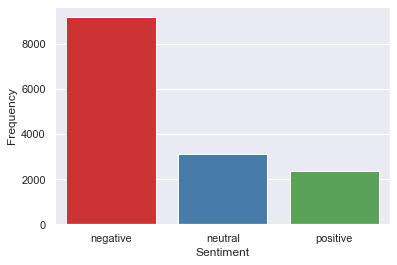

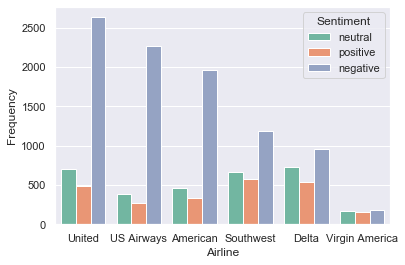

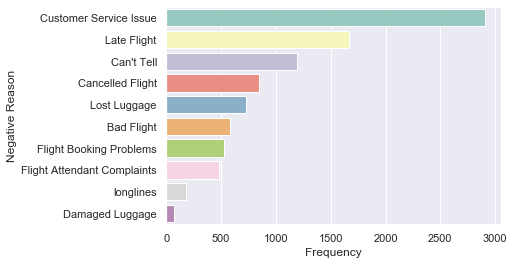

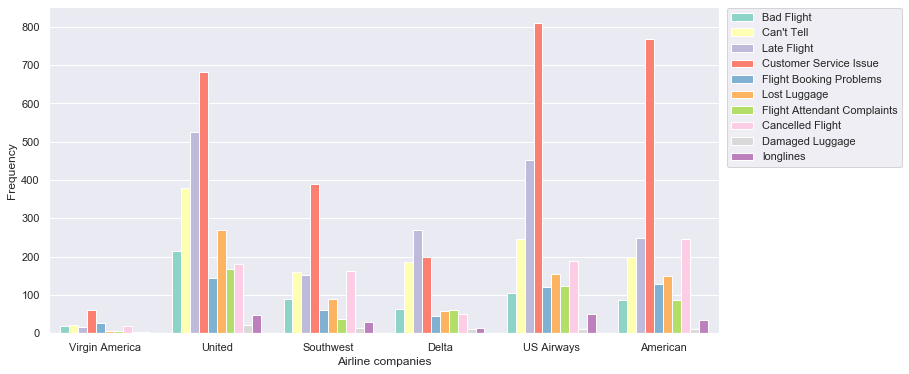

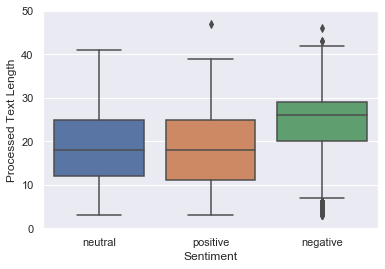

========================world cloud with negative sentiment==================================


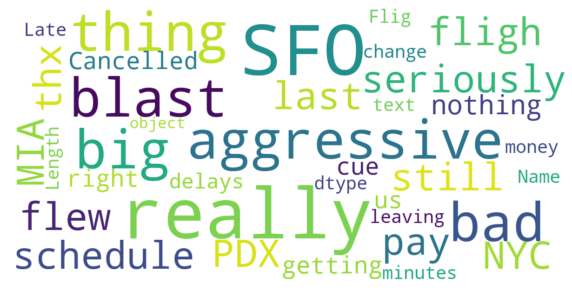

========================world cloud with neutral sentiment==================================


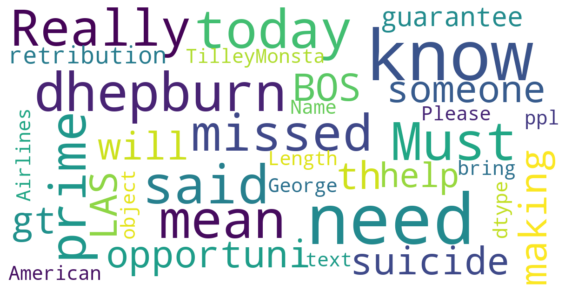

========================world cloud with positive sentiment==================================


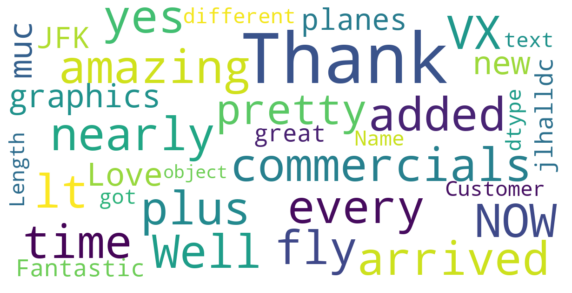

C:\Users\patri\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


-----------------------------------------
NB classification report --  feature: TFIDF/ ngram: 1/ sample_method: none/
Predicted    -1    0   1   All
True                          
-1         2717    8   0  2725
0           834  109   8   951
1           615   15  86   716
All        4166  132  94  4392
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.65      1.00      0.79      2725
           0       0.83      0.11      0.20       951
           1       0.91      0.12      0.21       716

    accuracy                           0.66      4392
   macro avg       0.80      0.41      0.40      4392
weighted avg       0.73      0.66      0.57      4392

Macro F1 Score: 0.40
Weighted F1 Score: 0.76
Train dataset calss distribution: 
 -1    6453
 1    6453
 0    6453
Name: label, dtype: int64
-----------------------------------------
NB classification report --  feature: TFIDF/ ngram: 1/ sample_method: oversampling/
Predict

In [ ]:
main()

# Random forest

In [27]:
def airline_random_forest(df, feature, ngram, sample_method):    
    random.seed(888)
        
    if feature == "TF":
        vector = CountVectorizer(analyzer = 'word', ngram_range=(1, ngram)) 
    elif feature == "TFIDF":        
        vector = TfidfVectorizer(analyzer = 'word', ngram_range=(1, ngram))
    
    train_X, test_X, train_y, test_y = train_test_split(df, df['label'], test_size = 0.2, random_state = 123)

    if sample_method == "undersampling":
        train_X = undersampling(train_X)
    
    elif sample_method == "oversampling":    
        train_X = oversampling(train_X)               
 
    pipe = make_pipeline(vector, RandomForestClassifier(n_estimators=100, random_state=0))
    pipe.fit(train_X['text'], train_X['label'])     
    
    test_y_hat = pipe.predict(test_X['text'])
        
    df_result = test_X.copy()
    df_result['prediction'] = test_y_hat.tolist()   
    
    df_prob = pd.DataFrame(pipe.predict_proba(test_X['text']), columns = pipe.classes_)
    df_prob.index = df_result.index
    df_prob.columns = ['probability_negative', 'Probability_neutral', 'probability_positive']

    df_final = pd.concat([df_result, df_prob], axis = 1)
    
    print("-----------------------------------------")
    print("random forest -- ", "feature: %s/" %feature, "ngram: %d/" %ngram, "sample_method: %s/" %sample_method)
    print(pd.crosstab(test_y.ravel(), test_y_hat, rownames = ['True'], colnames = ['Predicted'], margins = True))  
    
    print("-----------------------------------------")
    print(classification_report(test_y, test_y_hat))
    
    print('Macro F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'macro')))  

    print('Weighted F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'weighted'))) 

In [ ]:
for i in range(1,4):
    airline_model = airline_sub.loc[:, ['airline_sentiment', 'text', 'processed_text', 'label', 'label_doc2vec']]
    airline_random_forest(airline_model, "TFIDF", i, "none")  
    airline_random_forest(airline_model, "TFIDF", i, "oversampling")  
    airline_random_forest(airline_model, "TFIDF",i, "undersampling") 

C:\Users\patri\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


-----------------------------------------
random forest --  feature: TFIDF/ ngram: 1/ sample_method: none/
Predicted    -1    0    1   All
True                           
-1         1785   40   14  1839
0           375  236   27   638
1           214   33  204   451
All        2374  309  245  2928
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.75      0.97      0.85      1839
           0       0.76      0.37      0.50       638
           1       0.83      0.45      0.59       451

    accuracy                           0.76      2928
   macro avg       0.78      0.60      0.64      2928
weighted avg       0.77      0.76      0.73      2928

Macro F1 Score: 0.64
Weighted F1 Score: 0.79
Train dataset calss distribution: 
 -1    7339
 1    7339
 0    7339
Name: label, dtype: int64
-----------------------------------------
random forest --  feature: TFIDF/ ngram: 1/ sample_method: oversampling/
Predicted    -1    0   

C:\Users\patri\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


-----------------------------------------
random forest --  feature: TFIDF/ ngram: 2/ sample_method: none/
Predicted    -1    0    1   All
True                           
-1         1746   66   27  1839
0           349  263   26   638
1           175   39  237   451
All        2270  368  290  2928
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.77      0.95      0.85      1839
           0       0.71      0.41      0.52       638
           1       0.82      0.53      0.64       451

    accuracy                           0.77      2928
   macro avg       0.77      0.63      0.67      2928
weighted avg       0.76      0.77      0.75      2928

Macro F1 Score: 0.67
Weighted F1 Score: 0.79
Train dataset calss distribution: 
 -1    7339
 1    7339
 0    7339
Name: label, dtype: int64
-----------------------------------------
random forest --  feature: TFIDF/ ngram: 2/ sample_method: oversampling/
Predicted    -1    0   

C:\Users\patri\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


-----------------------------------------
random forest --  feature: TFIDF/ ngram: 3/ sample_method: none/
Predicted    -1    0    1   All
True                           
-1         1723   83   33  1839
0           326  289   23   638
1           162   53  236   451
All        2211  425  292  2928
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.78      0.94      0.85      1839
           0       0.68      0.45      0.54       638
           1       0.81      0.52      0.64       451

    accuracy                           0.77      2928
   macro avg       0.76      0.64      0.68      2928
weighted avg       0.76      0.77      0.75      2928

Macro F1 Score: 0.68
Weighted F1 Score: 0.78
Train dataset calss distribution: 
 -1    7339
 1    7339
 0    7339
Name: label, dtype: int64


# deep learning MLP

MLP avec relu

In [17]:
def MLP(df, feature, ngram, sample_method):    
    random.seed(888)
        
    if feature == "TF":
        vector = CountVectorizer(analyzer = 'word', ngram_range=(1, ngram)) 
    elif feature == "TFIDF":        
        vector = TfidfVectorizer(analyzer = 'word', ngram_range=(1, ngram))
    
    train_X, test_X, train_y, test_y = train_test_split(df, df['label'], test_size = 0.2, random_state = 123)

    if sample_method == "undersampling":
        train_X = undersampling(train_X)
    
    elif sample_method == "oversampling":    
        train_X = oversampling(train_X)               
 
    pipe = make_pipeline(vector, MLPClassifier( solver='lbfgs', random_state = 0,hidden_layer_sizes=[100]))
    pipe.fit(train_X['text'], train_X['label'])     
    
    test_y_hat = pipe.predict(test_X['text'])
        
    df_result = test_X.copy()
    df_result['prediction'] = test_y_hat.tolist()   
    
    df_prob = pd.DataFrame(pipe.predict_proba(test_X['text']), columns = pipe.classes_)
    df_prob.index = df_result.index
    df_prob.columns = ['probability_negative', 'Probability_neutral', 'probability_positive']

    df_final = pd.concat([df_result, df_prob], axis = 1)
    
     
    
    print("-----------------------------------------")
    print("MLP classification report -- ", "feature: %s/" %feature, "ngram: %d/" %ngram, "sample_method: %s/" %sample_method)
    print(pd.crosstab(test_y.ravel(), test_y_hat, rownames = ['True'], colnames = ['Predicted'], margins = True))  
    
    print("-----------------------------------------")
    print(classification_report(test_y, test_y_hat))
    
    print('Macro F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'macro')))  
    print('Weighted F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'weighted'))) 

In [ ]:
for i in range(1,4):
    airline_model = airline_sub.loc[:, ['airline_sentiment', 'text', 'processed_text', 'label', 'label_doc2vec']]
    MLP(airline_model, "TFIDF", i, "none")  
    MLP(airline_model, "TFIDF", i, "oversampling")  
    MLP(airline_model, "TFIDF",i, "undersampling") 

C:\Users\patri\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


-----------------------------------------
MLP classification report --  feature: TFIDF/ ngram: 1/ sample_method: none/
Predicted    -1    0    1   All
True                           
-1         1566  198   75  1839
0           231  353   54   638
1            66   67  318   451
All        1863  618  447  2928
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.84      0.85      0.85      1839
           0       0.57      0.55      0.56       638
           1       0.71      0.71      0.71       451

    accuracy                           0.76      2928
   macro avg       0.71      0.70      0.71      2928
weighted avg       0.76      0.76      0.76      2928

Macro F1 Score: 0.71
Weighted F1 Score: 0.77
Train dataset calss distribution: 
 -1    7339
 1    7339
 0    7339
Name: label, dtype: int64
-----------------------------------------
MLP classification report --  feature: TFIDF/ ngram: 1/ sample_method: oversampling/

C:\Users\patri\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


MLP avec la tangente hyperbolique

In [ ]:
def MLP(df, feature, ngram, sample_method):    
    random.seed(888)
        
    if feature == "TF":
        vector = CountVectorizer(analyzer = 'word', ngram_range=(1, ngram)) 
    elif feature == "TFIDF":        
        vector = TfidfVectorizer(analyzer = 'word', ngram_range=(1, ngram))
    
    train_X, test_X, train_y, test_y = train_test_split(df, df['label'], test_size = 0.2, random_state = 123)

    if sample_method == "undersampling":
        train_X = undersampling(train_X)
    
    elif sample_method == "oversampling":    
        train_X = oversampling(train_X)               
 
    pipe = make_pipeline(vector, MLPClassifier( solver='lbfgs',activation='tanh', random_state = 0,hidden_layer_sizes=[100]))
    pipe.fit(train_X['text'], train_X['label'])    
    
    test_y_hat = pipe.predict(test_X['text'])
        
    df_result = test_X.copy()
    df_result['prediction'] = test_y_hat.tolist()   
    
    df_prob = pd.DataFrame(pipe.predict_proba(test_X['text']), columns = pipe.classes_)
    df_prob.index = df_result.index
    df_prob.columns = ['probability_negative', 'Probability_neutral', 'probability_positive']

    df_final = pd.concat([df_result, df_prob], axis = 1)
    
#     file_name = 'SVM_' + str(ngram) + '_' + sample_method 
#     df_final.to_csv(file_name + '.csv')       
    
    print("-----------------------------------------")
    print("MLP classification report -- ", "feature: %s/" %feature, "ngram: %d/" %ngram, "sample_method: %s/" %sample_method)
    print(pd.crosstab(test_y.ravel(), test_y_hat, rownames = ['True'], colnames = ['Predicted'], margins = True))  
    
    print("-----------------------------------------")
    print(classification_report(test_y, test_y_hat))
    
    print('Macro F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'macro')))  
    print('Weighted F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'weighted'))) 

In [ ]:
for i in range(1,4):
    airline_model = airline_sub.loc[:, ['airline_sentiment', 'text', 'processed_text', 'label', 'label_doc2vec']]
    MLP(airline_model, "TFIDF", i, "none")  
    MLP(airline_model, "TFIDF", i, "oversampling")  
    MLP(airline_model, "TFIDF",i, "undersampling") 

C:\Users\patri\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


-----------------------------------------
MLP classification report --  feature: TFIDF/ ngram: 1/ sample_method: none/
Predicted    -1    0    1   All
True                           
-1         1558  201   80  1839
0           227  356   55   638
1            59   64  328   451
All        1844  621  463  2928
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.84      0.85      0.85      1839
           0       0.57      0.56      0.57       638
           1       0.71      0.73      0.72       451

    accuracy                           0.77      2928
   macro avg       0.71      0.71      0.71      2928
weighted avg       0.76      0.77      0.77      2928

Macro F1 Score: 0.71
Weighted F1 Score: 0.77
Train dataset calss distribution: 
 -1    7339
 1    7339
 0    7339
Name: label, dtype: int64
-----------------------------------------
MLP classification report --  feature: TFIDF/ ngram: 1/ sample_method: oversampling/

C:\Users\patri\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


-----------------------------------------
MLP classification report --  feature: TFIDF/ ngram: 2/ sample_method: none/
Predicted    -1    0    1   All
True                           
-1         1676  118   45  1839
0           214  380   44   638
1            62   56  333   451
All        1952  554  422  2928
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.86      0.91      0.88      1839
           0       0.69      0.60      0.64       638
           1       0.79      0.74      0.76       451

    accuracy                           0.82      2928
   macro avg       0.78      0.75      0.76      2928
weighted avg       0.81      0.82      0.81      2928

Macro F1 Score: 0.76
Weighted F1 Score: 0.82
Train dataset calss distribution: 
 -1    7339
 1    7339
 0    7339
Name: label, dtype: int64
-----------------------------------------
MLP classification report --  feature: TFIDF/ ngram: 2/ sample_method: oversampling/

C:\Users\patri\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# LDA

In [50]:
def LDA (df, feature, ngram, sample_method):    
    random.seed(888)
        
    if feature == "TF":
        vector = CountVectorizer(analyzer = 'word', ngram_range=(1, ngram)) 
    elif feature == "TFIDF":        
        vector = TfidfVectorizer(analyzer = 'word', ngram_range=(1, ngram))
    
    train_X, test_X, train_y, test_y = train_test_split(df, df['label'], test_size = 0.2, random_state = 123)

    if sample_method == "undersampling":
        train_X = undersampling(train_X)
    
    elif sample_method == "oversampling":    
        train_X = oversampling(train_X)               
 
    pipe = make_pipeline(vector, LinearDiscriminantAnalysis())
    pipe.fit(train_X['text'], train_X['label'])     
    
    test_y_hat = pipe.predict(test_X['text'])
        
    df_result = test_X.copy()
    df_result['prediction'] = test_y_hat.tolist()   
    
    df_prob = pd.DataFrame(pipe.predict_proba(test_X['text']), columns = pipe.classes_)
    df_prob.index = df_result.index
    df_prob.columns = ['probability_negative', 'Probability_neutral', 'probability_positive']

    df_final = pd.concat([df_result, df_prob], axis = 1)
          
    
    print("-----------------------------------------")
    print("LDA classification report -- ", "feature: %s/" %feature, "ngram: %d/" %ngram, "sample_method: %s/" %sample_method)
    print(pd.crosstab(test_y.ravel(), test_y_hat, rownames = ['True'], colnames = ['Predicted'], margins = True))  
    
    print("-----------------------------------------")
    print(classification_report(test_y, test_y_hat))
    
    print('Macro F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'macro')))  
    print('Weighted F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'weighted')))  

In [51]:
for i in range(1,4):
    airline_model = airline_sub.loc[:, ['airline_sentiment', 'text', 'processed_text', 'label', 'label_doc2vec']]
    LDA(airline_model, "TFIDF", i, "none")  
    LDA(airline_model, "TFIDF", i, "oversampling")  
    LDA(airline_model, "TFIDF",i, "undersampling") 

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

# looking for a gridsearch

In [66]:
def airline_SVM(df, feature, ngram, sample_method):    
    random.seed(888)      
    vector = TfidfVectorizer(analyzer = 'word', ngram_range=(1, ngram))
    
    train_X, test_X, train_y, test_y = train_test_split(df, df['label'], test_size = 0.2, random_state = 123)

    if sample_method == "undersampling":
        train_X = undersampling(train_X)
    
    elif sample_method == "oversampling":    
        train_X = oversampling(train_X)               
 
    pipe = make_pipeline(vector,(svm.SVC()))
    param_grid=[{'classifier ':[svm.SVC()], 
               'classifier__gamma':[0.001,0.01,0,1,10,100], 
              'classifier__c':[0.001,0.01,0,1,10,100]}]
    grid=GridSearchCV(pipe, param_grid, cv=5)
    gris.fit(train_X['text'], train_X['label'])
    print(grid.score(test_X,test_y))

In [69]:
airline_model = airline_sub.loc[:, ['airline_sentiment', 'text', 'processed_text', 'label', 'label_doc2vec']]
airline_SVM(airline_model, "TFIDF", i, "none")  

NameError: name 'C' is not defined

In [31]:
 def airline_SVM(df, feature, ngram, sample_method):    
    random.seed(888)
        
    if feature == "TF":
        vector = CountVectorizer(analyzer = 'word', ngram_range=(1, ngram)) 
    elif feature == "TFIDF":        
        vector = TfidfVectorizer(analyzer = 'word', ngram_range=(1, ngram))
    
    train_X, test_X, train_y, test_y = train_test_split(df, df['label'], test_size = 0.2, random_state = 123)

    if sample_method == "undersampling":
        train_X = undersampling(train_X)
    
    elif sample_method == "oversampling":    
        train_X = oversampling(train_X)               
   
    best_score=0
    for gamma in [0.001,0.01,0,1,10,100]:
        for C in [0.001,0.01,0,1,10,100]:
            pipe = pipeline(vector, svm.SVC(C=C, kernel = 'linear', gamma=gamma,probability = True, random_state = 123))
            pipe.fit(train_X['text'], train_X['label'])     
            score=pipe.score_samples(test_X)
            if socre>best_score:
                best_score=score
                best_params={'C':C, 'gamma':gamma}

In [32]:
    airline_model = airline_sub.loc[:, ['airline_sentiment', 'text', 'processed_text', 'label', 'label_doc2vec']]
    airline_SVM(airline_model, "TFIDF", 1, "none") 
    airline_SVM(airline_model, "TFIDF", 1, "oversampling") 
    airline_SVM(airline_model, "TFIDF", 1, "undersampling") 

TypeError: 'module' object is not callable